In [14]:
import pden
import pden.Net
import pden.Operations
import pden.PDENet

import tensorflow as tf

import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from IPython.display import clear_output

%load_ext autoreload
%autoreload 1

%aimport pden.Net
%aimport pden.Operations
%aimport pden.PDENet

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
def der(y, x, y_shape: int, x_shape: int):
    ys = tf.split(y, [1] * y_shape, 1)
    def _der(i, j=[]):
        f = ys[i]
        for _j in j:
            fs = tf.gradients(f, x)[0]
            f  = tf.split(fs, [1] * x_shape, 1)[_j]        
        return f
    return _der

In [16]:
k = 32
net1 = pden.Net.BasicNet(
    pden.Operations.Linear(feature_out=k, feature_in=2, random_init = True),
    pden.Operations.ActivationFunction(tf.cos),
    pden.Operations.Linear(feature_in=k, feature_out=k, random_init = True),
    pden.Operations.ActivationFunction(tf.cos),
#     pden.Operations.Linear(feature_in=k, feature_out=k, random_init = True),
#     pden.Operations.ActivationFunction(tf.nn.tanh),
    pden.Operations.Linear(feature_in=k, feature_out=1, random_init = True)
)

net2 = pden.Net.BasicNet(
    pden.Operations.Linear(feature_out=k, feature_in=2, random_init = True),
    pden.Operations.ActivationFunction(tf.cos),
    pden.Operations.Linear(feature_in=k, feature_out=k, random_init = True),
    pden.Operations.ActivationFunction(tf.cos),
#     pden.Operations.Linear(feature_in=k, feature_out=k, random_init = True),
#     pden.Operations.ActivationFunction(tf.nn.tanh),
    pden.Operations.Linear(feature_in=k, feature_out=1, random_init = True)
)

pnet1 = pden.PDENet.PDENET(net=net1)
pnet2 = pden.PDENet.PDENET(net=net2)

print(net1)
print(net2)

Net 31:
	32	Linear: [2 -> 32]
	9	Activation funciton: <function cos at 0x11a434830>
	10	Linear: [32 -> 32]
	0	Activation funciton: <function cos at 0x11a434830>
	7	Linear: [32 -> 1]
Net 23:
	6	Linear: [2 -> 32]
	8	Activation funciton: <function cos at 0x11a434830>
	17	Linear: [32 -> 32]
	14	Activation funciton: <function cos at 0x11a434830>
	5	Linear: [32 -> 1]


In [17]:
x = tf.placeholder(tf.float64, [None, 2])
# u = pnet1.forward(x)
# u1, u2 = tf.split(u, [1, 1], 1)
u1, u2 = pnet1.forward(x), pnet2.forward(x)

x0 = tf.placeholder(tf.float64, [None, 2])
# ux0 = pnet1.forward(x0)
# u1x0, u2x0 = tf.split(ux0, [1, 1], 1)
u1x0, u2x0 = pnet1.forward(x0), pnet2.forward(x0)

t0 = tf.placeholder(tf.float64, [None, 2])
# ut0 = pnet1.forward(t0)
# u1t0, u2t0 = tf.split(ut0, [1, 1], 1)
u1t0, u2t0 = pnet1.forward(t0), pnet2.forward(t0)

t1 = tf.placeholder(tf.float64, [None, 2])
# ut1 = pnet1.forward(t1)
# u1t1, u2t1 = tf.split(ut1, [1, 1], 1)
u1t1, u2t1 = pnet1.forward(t1), pnet2.forward(t1)

der_gen1 = der(u1, x, 1, 2)
der_gen2 = der(u2, x, 1, 2)

du1_dx = der_gen1(0, j=[0])
du1_dt = der_gen1(0, j=[1])

du2_dx = der_gen2(0, j=[0])
du2_dt = der_gen2(0, j=[1])

# du1, du2 = der_gen(0, j=[0, 1]), der_gen(1, j=[0, 1])

In [18]:
_x, _t = tf.split(x, [1, 1], 1)

In [19]:
pnet1 = pnet1.add_loss(tf.reduce_mean(tf.pow(du1_dx + du2_dt - _t * tf.cos(_x) + _x * tf.sin(_t), 2)))
pnet1 = pnet1.add_loss(tf.reduce_mean(tf.pow(du1_dt + du2_dx - _x * tf.cos(_t) + _t * tf.sin(_x), 2)))

pnet1 = pnet1.add_loss(tf.reduce_mean(tf.pow(u1x0, 2)))
pnet1 = pnet1.add_loss(tf.reduce_mean(tf.pow(u1t0, 2)))
pnet1 = pnet1.add_loss(tf.reduce_mean(tf.pow(u1t1 - tf.sin(_x), 2)))

pnet1 = pnet1.add_loss(tf.reduce_mean(tf.pow(u2t0 - 1.0, 2)))
pnet1 = pnet1.add_loss(tf.reduce_mean(tf.pow(u2x0 - 1.0, 2)))
pnet1 = pnet1.add_loss(tf.reduce_mean(tf.pow(u2t1 - tf.cos(_x), 2)))

# pnet2 = pnet1.add_loss(tf.reduce_mean(tf.pow(du1_dx + du2_dt - _t * tf.cos(_x) + _x * tf.sin(_t), 2)))
# pnet2 = pnet1.add_loss(tf.reduce_mean(tf.pow(du1_dt + du2_dx - _x * tf.cos(_t) + _t * tf.sin(_x), 2)))

# pnet2 = pnet2.add_loss(tf.reduce_mean(tf.pow(u1x0, 2)))
# pnet2 = pnet2.add_loss(tf.reduce_mean(tf.pow(u1t0, 2)))
# pnet2 = pnet2.add_loss(tf.reduce_mean(tf.pow(u1t1 - tf.sin(_x), 2)))

# pnet2 = pnet2.add_loss(tf.reduce_mean(tf.pow(u2t0 - 1.0, 2)))
# pnet2 = pnet2.add_loss(tf.reduce_mean(tf.pow(u2x0 - 1.0, 2)))
# pnet2 = pnet2.add_loss(tf.reduce_mean(tf.pow(u2t1 - tf.cos(_x), 2)))

In [20]:
learning_rate = 5e-2
training_epochs = 6000
display_step = 250

loss = pnet1.loss

opt = tf.train.AdamOptimizer(learning_rate = learning_rate)
train = opt.minimize(loss)

init = tf.global_variables_initializer()

In [21]:
losses = []

In [22]:
sess = tf.Session()
sess.run(init)

for epoch in range(training_epochs):
    
#     P = np.random.uniform(0, 0.5, size=(1,))
    
    X = np.random.rand(100, 2)
    X0= np.random.rand(100, 2)
    X0[:, 0] = 0
    T1= np.random.rand(100, 2)
    T1[:, 1] = 1
    T0= np.random.rand(100, 2)
    T0[:, 1] = 0
    
    _, l = sess.run([train, loss], feed_dict={
        x: X,
        x0: X0,
        t0: T0, 
        t1: T1
    })
    
#     l /= 2
    
    losses.append(l)
    
    if epoch % display_step == 0 and True:
        print(f'Training error for net is "{l}". Epoch {epoch}')

        
print("Optimization Finished!")

Training error for net is "1196.302262206018". Epoch 0
Training error for net is "0.15985065560903527". Epoch 250
Training error for net is "0.11791225077990744". Epoch 500
Training error for net is "0.11572841054152036". Epoch 750
Training error for net is "0.11041377661343224". Epoch 1000
Training error for net is "0.15111973118898692". Epoch 1250
Training error for net is "0.4759324663920722". Epoch 1500
Training error for net is "0.12286027167002639". Epoch 1750
Training error for net is "0.13835761664781301". Epoch 2000
Training error for net is "0.14121479535510092". Epoch 2250
Training error for net is "0.14596066068745495". Epoch 2500
Training error for net is "0.11275363248930048". Epoch 2750
Training error for net is "0.15565013180986226". Epoch 3000
Training error for net is "0.1127048264115772". Epoch 3250
Training error for net is "0.10567825319256428". Epoch 3500
Training error for net is "0.10835852700430812". Epoch 3750
Training error for net is "0.09993669468546562". E

In [13]:
# l_tanh = losses

In [23]:
# l_cos = losses

In [196]:
# l_cos_8 = losses

In [197]:
# l_cos_64 = losses

In [36]:
xt = np.array(l_tanh[:1000:100])
xc = np.array(l_cos[:1000:100])
# yt = np.array(l_cos_8[:2500:100])
# yc = np.array(l_cos_64[:2500:100])

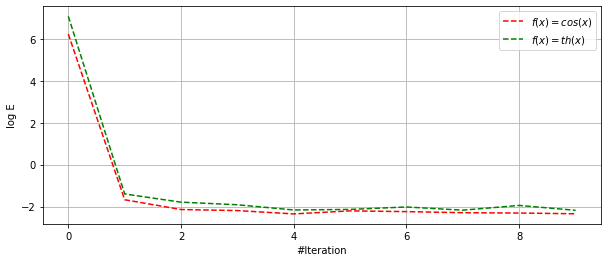

In [39]:
plt.figure(figsize=(10, 4))
plt.plot(np.log(xt), '--r', label=r'$f(x)=cos(x)$')
plt.plot(np.log(xc), '--g', label=r'$f(x)=th(x)$')
# plt.plot(np.log(yt), '--y', label=r'$\phi=cos, k = 8$')
# plt.plot(np.log(yc), '--b', label=r'$\phi=cos, k = 64$')
plt.grid()
plt.xlabel('#Iteration')
plt.ylabel('log E')
plt.legend()
plt.show()